In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import time


import skimage.io as img_io
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.contrib import layers as ly

gpu_opt = tf.ConfigProto(gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95 , allow_growth=True) 
                             ,device_count={'GPU': 1})

/home/derricksu/Envs/py36_MLDS/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_root = "data"
train_path = os.path.join( data_root , "train" )
test_path = os.path.join( data_root , "test" )

train_attribute = np.genfromtxt( train_path+".csv" , delimiter="," , skip_header=0 , dtype="str")
test_attribute = np.genfromtxt( test_path+".csv" , delimiter="," , skip_header=0 , dtype="str")


attr = train_attribute[0,1::]
print("Attribute : ")
print(" , ".join(attr[1:8]))
print(" , ".join(attr[8::]))


Attribute : 
Big_Lips , Black_Hair , Blond_Hair , Brown_Hair , Heavy_Makeup , High_Cheekbones , Male
Mouth_Slightly_Open , Smiling , Straight_Hair , Wavy_Hair , Wearing_Lipstick


In [3]:
train_id = train_attribute[1:,0]
train_attribute = train_attribute[1:,1::].astype("float")

test_id = test_attribute[1:,0]
test_attribute = test_attribute[1:,1::].astype("float")

training_attribute = np.concatenate([train_attribute , test_attribute] , axis=0)

print("Total traing data : " , training_attribute.shape)

Total traing data :  (42621, 13)


In [4]:
## load image
training_img = []
for f in train_id:
    training_img.append( img_io.imread( os.path.join( train_path , f ) ) )

for f in test_id:
    training_img.append( img_io.imread( os.path.join( test_path , f ) ) )

    
training_img = np.array(training_img).astype("float")

print("Shape of training data :" , training_img.shape)

Shape of training data : (42621, 64, 64, 3)


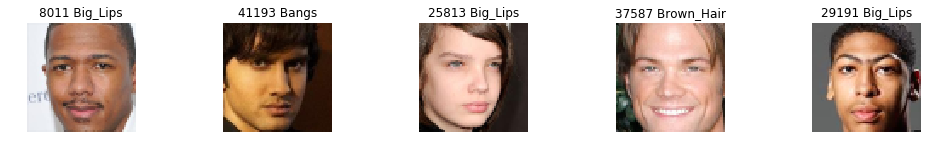

In [5]:
k = 5
idx = np.random.choice(42621, size=k)

fig = plt.figure(figsize=(3*k+2,2))
for i,img_name in enumerate( idx ):
    ax = fig.add_subplot( 1,k , i+1 )
    ax.imshow( training_img[img_name].astype("int") )
    ax.axis("off")
    a = np.argmax(training_attribute[img_name])
    
    ax.set_title(str(img_name)+" "+attr[a])
plt.show()


(-0.5, 518.5, 258.5, -0.5)

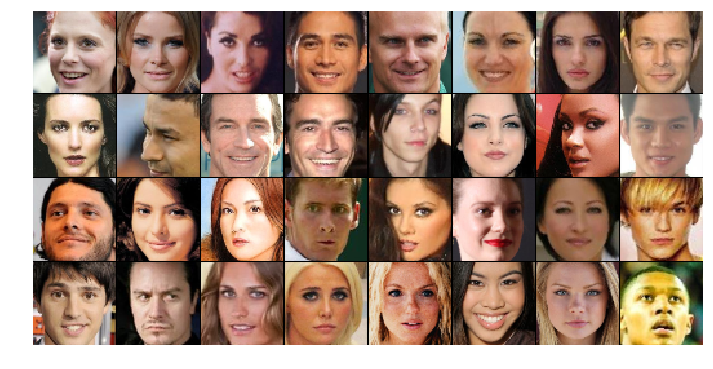

In [6]:
def concat_img(g , col=8):
    concat_all_img = []
    img_count = g.shape[0]
    row_padding = np.zeros(shape=[1 , g.shape[2]*col+col-1,3])
    col_padding = np.zeros(shape=[g.shape[1],1,3])
    for i in range(img_count//col):
        a = g[i*col]
        for j in range(1,col):
            a = np.concatenate( [ a , col_padding , g[ i*col+j ]  ] , axis=1  )
        concat_all_img.append(a)
        if i == (img_count//col-1):
            break
        concat_all_img.append(row_padding)
    return np.concatenate( concat_all_img , axis=0 )

test1 = training_img[0:32]
concat_test = concat_img( test1 ).astype("int")

plt.figure(figsize=(12,8))
plt.imshow(concat_test)
plt.axis("off")

In [7]:
processing_input = lambda x : (x/255-0.5)*2
inverse_processing = lambda x : (x/2+0.5)*255

In [8]:
train_data = processing_input(training_img)

## Build GAN

[Tutorial](https://github.com/jonbruner/generative-adversarial-networks/blob/master/gan-notebook.ipynb)  by Jon Bruner and Adit Deshpande
  
[Tips](https://github.com/soumith/ganhacks)

In [9]:
def Descriminate( inputs , reuse_flag=None ):
    """
    Defined by GAN.
    The model is to descriminate real image or fake image.
    Design with ConvNet and add batch normalization.
    
    Args:
        inputs : a 4-D tensor , shape is [64,64,3]. Dtype must be float.
        reuse_flag : a boolean value. Notice that it should be true while training generative model
    
    return:
        2-D tensor : [batch size , score].
    """
    print("Build descriminator")
    x = ly.conv2d( inputs , 64 , kernel_size=[5,5] , stride=[2,2] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_w_1")
    x = ly.conv2d( x , 128 , kernel_size=[3,3] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_w_2" )
    x = ly.avg_pool2d( x , [3,3] , stride=[2,2] , padding="VALID" , scope="d_pool_w_1" ) 
    
    x = ly.conv2d( x , 128 , kernel_size=[3,3] , stride=[1,1] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_w_3" )
    x = ly.conv2d( x , 256 , kernel_size=[3,3] , stride=[2,2] , padding="VALID" , activation_fn=tf.nn.leaky_relu
                  , reuse=reuse_flag , scope="d_conv_w_4" )
#     x = ly.max_pool2d( x , [3,3] , stride=[2,2] , padding="VALID" , scope="d_pool_w_2" )
    
    x = ly.flatten( x , scope="d_flat" )
    print(x.shape)
    x = ly.fully_connected( x , 256 , activation_fn=tf.nn.leaky_relu , reuse=reuse_flag , scope="d_fc_1" )
    x = ly.fully_connected( x , 128 , activation_fn=tf.nn.leaky_relu , reuse=reuse_flag , scope="d_fc_2" )
    print(x.shape)
#     x = ly.batch_norm( x , reuse=reuse_flag , scope="d_bn_4")
#     x = ly.fully_connected( x , 128 , reuse=reuse_flag , scope="d_fc_3" )
    x = ly.fully_connected( x , 1 , activation_fn=tf.nn.sigmoid
                           , reuse=reuse_flag , scope="d_fc_4" )
    
    return x
    

def Descriminate_str( inputs , reuse_flag=None ):
    """
    Defined by GAN.
    The model is to descriminate real image or fake image.
    Design with ConvNet and add batch normalization.
    
    Args:
        inputs : a 4-D tensor , shape is [64,64,3]. Dtype must be float.
        reuse_flag : a boolean value. Notice that it should be true while training generative model
    
    return:
        2-D tensor : [batch size , score].
    """
    print("Build descriminator")
    x = ly.conv2d( inputs , 256 , [5,5] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_1" )
    x = ly.conv2d( x , 256 , [3,3] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_2" )
    x = ly.avg_pool2d( x , [3,3] , stride=[2,2] , scope="d_pool_1" )
    ## shape is [28,28]
    print(x.shape)
#     x = ly.batch_norm( x , reuse=reuse_flag , scope="d_bn_1")
    x = ly.conv2d( x , 128 , [3,3] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_3" )
    x = ly.conv2d( x , 96 , [1,1] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_4" )
    x = ly.conv2d( x , 128 , [3,3] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_5" )
    x = ly.avg_pool2d( x , [3,3] , stride=[2,2] , padding="VALID" , scope="d_pool_2" )
    ## shape is [11,11]
    print(x.shape)
#     x = ly.batch_norm( x , reuse=reuse_flag , scope="d_bn_2")
    x = ly.conv2d( x , 96 , [3,3] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_6" )
    x = ly.conv2d( x , 64 , [1,1] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_7" )
    x = ly.conv2d( x , 96 , [3,3] , stride=[1,1] , padding="VALID" , reuse=reuse_flag , scope="d_8" )
#     x = ly.avg_pool2d( x , [2,2] , stride=[2,2] , padding="VALID" , scope="d_pool_3" )
    ## shape is [6,6]
    print(x.shape)
#     x = ly.batch_norm( x , reuse=reuse_flag , scope="d_bn_3")
    x = tf.contrib.layers.flatten(x)
    print(x.shape)
    x = ly.fully_connected( x , 256 , reuse=reuse_flag , scope="d_fc_1" )
    x = ly.fully_connected( x , 128 , reuse=reuse_flag , scope="d_fc_2" )
    print(x.shape)
#     x = ly.batch_norm( x , reuse=reuse_flag , scope="d_bn_4")
#     x = ly.fully_connected( x , 128 , reuse=reuse_flag , scope="d_fc_3" )
    x = ly.fully_connected( x , 1 , activation_fn=tf.nn.sigmoid 
                           , reuse=reuse_flag , scope="d_fc_4" )
    
    return x
    

In [10]:
def Generate( z ):
    """
    Defined by GAN.
    The model is to generate image to cheat descrinator.
    Design with Conv2DTranspose and add batch normalization.
    
    Args:
        inputs : a 2-D tensor , shape is [batch size , z_dim]. Dtype must be float.
                Notice : z_dim nust be multiple of 4
    
    return:
        4-D tensor : [batch size , 64 , 64 , 3].
    """
    print("Build generator")
    ## z is 512
    x = tf.reshape(z , [-1,1,1,latent_dim])
    x = ly.conv2d( x , 4096 , [1,1] , stride=[1,1] , activation_fn=tf.nn.leaky_relu , scope="g_conv_0")
    x = tf.reshape( x , [ -1,2,2,4096//4 ] )
    x = ly.conv2d_transpose( x , 1024 , [4,4] , stride=[2,2] , activation_fn=tf.nn.leaky_relu
                            , padding="SAME" , scope="g_0")
    print(x.shape)
    ## 4x4x128
    x = ly.batch_norm( x , scope="g_bn_1")
    x = ly.conv2d_transpose( x , 512 , [4,4] , stride=[2,2] , activation_fn=tf.nn.leaky_relu
                            , padding="SAME" , scope="g_1")
    
#     print(x.shape)
    ## 4x4  why should kernel size be 6x6 not 5x5 ? 
    x = ly.conv2d_transpose( x , 256 , [8,8] , stride=[4,4] , activation_fn=tf.nn.leaky_relu
                            , padding="SAME" , scope="g_2")
    x = ly.batch_norm( x , scope="g_bn_2")
    
    x = ly.conv2d_transpose( x , 128 , [5,5] , stride=[2,2] , activation_fn=tf.nn.leaky_relu
                            , padding="SAME" , scope="g_3")
    print(x.shape)
#     x = ly.conv2d_transpose( x , 3 , [3,3] , stride=[1,1] , activation_fn=tf.nn.sigmoid
#                             , padding="SAME" , scope="g_4")
    
    ## 64x64x8
#     x = ly.conv2d_transpose( x , 128 , [4,4] , stride=[2,2] , activation_fn=tf.nn.selu
#                             , padding="SAME" , scope="g_4")
    ## 64x64x3
#     x = ly.conv2d( x , 96 , [1,1] , stride=[1,1] , activation_fn=tf.nn.leaky_relu , scope="g_conv_3" )
    x = ly.conv2d( x , 3 , [1,1] , stride=[1,1] , activation_fn=tf.nn.tanh , scope="g_conv_4" )
    
    return x

In [11]:
def avoid_nan(y,x):
    return tf.maximum(x,0)-x*y+tf.log( 1+tf.exp(-tf.abs(x)) )

In [12]:
tf.reset_default_graph()

In [13]:
GAN_graph = tf.Graph()
logdir="GAN-ver0"
with GAN_graph.as_default():
    latent_dim=256
    
    with tf.name_scope("Input"):
        img = tf.placeholder( shape=[None,64,64,3] , dtype=tf.float32 , name="image")
        ys = tf.placeholder( shape=[None,1] , dtype=tf.float32 , name="label")

        z_input = tf.placeholder( shape=[None,latent_dim] , dtype=tf.float32 , name="latent_space")
    
    with tf.name_scope("Generator"):
        g_img = Generate(z_input)
    
    with tf.name_scope("Descriminator"):
        d_score = Descriminate(img)
        
        g_score = Descriminate(g_img , reuse_flag=True)
    
    with tf.name_scope("Loss"):
        d_loss_real = tf.reduce_mean(-( ys*tf.log( tf.clip_by_value(d_score,1e-10,1) ) ))
        d_loss_fake = tf.reduce_mean(-(1-ys)*tf.log( tf.clip_by_value(1-d_score,1e-10,1) ) )
        d_loss = d_loss_real+d_loss_fake
        g_loss = tf.reduce_mean(-tf.log( tf.clip_by_value(g_score,1e-10,1) ) )
        
#         d_loss = tf.reduce_mean(avoid_nan(ys,d_score))
        
#         g_loss = tf.reduce_mean(avoid_nan(tf.ones_like(g_score) , g_score))
        
    with tf.name_scope("Acc"):
        acc = tf.cast(tf.equal(tf.cast(tf.greater( d_score , 0.5 ) , tf.float32 ), ys ) , tf.float32)
        acc = tf.reduce_mean(acc)
                

    tvars = tf.trainable_variables()

    for v in tvars:
        if "d_" in v.name:
            tf.add_to_collection( "desc" , v )
        elif "g_" in v.name:
            tf.add_to_collection( "gene" , v )

    print("Descrimimator : " , [v.name for v in tf.get_collection("desc")])
    print()
    print("Generator : " , [v.name for v in tf.get_collection("gene")])
    
    with tf.name_scope("train_strategy"):
        # Train the discriminator
        d_trainer = tf.train.RMSPropOptimizer(7.5e-5).minimize(d_loss, var_list=tf.get_collection("desc"))

        # Train the generator
        g_trainer = tf.train.AdamOptimizer(5e-5).minimize(g_loss, var_list=tf.get_collection("gene"))

    # Initialize
    init = tf.global_variables_initializer()
    
    # From this point forward, reuse variables
    tf.get_variable_scope().reuse_variables()
    with tf.name_scope("image_generate"):
        images_for_tensorboard = Generate(z_input)
#     tf.summary.image('Generated_images', images_for_tensorboard, 5)
    
    g_summary = tf.summary.scalar('Generator_loss', g_loss)
    
    d_summry = tf.summary.merge([tf.summary.scalar('Discriminator_loss', d_loss)
                                ,tf.summary.scalar('Discriminator_acc', acc)])
    
#     merged = tf.summary.merge_all()
    writer_g = tf.summary.FileWriter("tb_logs/{}".format(logdir) , graph=GAN_graph)
    writer_real = tf.summary.FileWriter("tb_logs/{}/real".format(logdir))
    writer_fake = tf.summary.FileWriter("tb_logs/{}/fake".format(logdir))
    
    saver = tf.train.Saver(var_list=tf.get_collection("gene"))
    

Build generator
(?, 4, 4, 1024)
(?, 64, 64, 128)
Build descriminator
(?, 6400)
(?, 128)
Build descriminator
(?, 6400)
(?, 128)
Descrimimator :  ['d_conv_w_1/weights:0', 'd_conv_w_1/biases:0', 'd_conv_w_2/weights:0', 'd_conv_w_2/biases:0', 'd_conv_w_3/weights:0', 'd_conv_w_3/biases:0', 'd_conv_w_4/weights:0', 'd_conv_w_4/biases:0', 'd_fc_1/weights:0', 'd_fc_1/biases:0', 'd_fc_2/weights:0', 'd_fc_2/biases:0', 'd_fc_4/weights:0', 'd_fc_4/biases:0']

Generator :  ['g_conv_0/weights:0', 'g_conv_0/biases:0', 'g_0/weights:0', 'g_0/biases:0', 'g_bn_1/beta:0', 'g_1/weights:0', 'g_1/biases:0', 'g_2/weights:0', 'g_2/biases:0', 'g_bn_2/beta:0', 'g_3/weights:0', 'g_3/biases:0', 'g_conv_4/weights:0', 'g_conv_4/biases:0']
Build generator
(?, 4, 4, 1024)
(?, 64, 64, 128)


In [14]:
d_score

<tf.Tensor 'Descriminator/d_fc_4/Sigmoid:0' shape=(?, 1) dtype=float32>

### Training

while training descriminator 3 times , training generator 1 time.

In [15]:
sess = tf.Session( graph=GAN_graph , config=gpu_opt )
sess.run(init)

In [16]:
def shuffle_data():
    global train_data , r_index
    
    np.random.shuffle(r_index)
    return train_data[r_index]


In [ ]:
n_step = 120
n_batch = 200
d_training_count = 2

r_index = np.arange(train_data.shape[0])
data_x = train_data

start = 0
fake = 0
real = 0
l = 0
accuracy = 0
s=0
# for s in range(n_step):
while(accuracy<0.9):
    print( "Step {0:d} loss:{3:.4f} fake:{1:.4f} real:{2:.4f} acc:{4:.3f}".format(s+1 , fake , real , l , accuracy) , end="\r" )
    s+=1
    if (start+n_batch) > train_data.shape[0]:
        start = 0
        data_x = shuffle_data()
    s+=1
    batch_z = np.random.randn(n_batch,latent_dim)
    batch_g_img = sess.run( g_img , feed_dict={z_input:batch_z} )
    
    batch_x = np.concatenate([data_x[start:start+n_batch] , batch_g_img],axis=0)
    batch_y = np.concatenate([np.ones(shape=[n_batch,1]) , np.zeros(shape=[n_batch,1])] ,axis=0 )

    _ , l , accuracy = sess.run([d_trainer , d_loss , acc ] ,feed_dict={ img:batch_x , ys:batch_y })
#     print(l)
#     _ , fake = sess.run( [d_summry , d_loss_fake] ,feed_dict={ img:batch_x[n_batch:] , ys:batch_y[n_batch:] })
#     writer_fake.add_summary(_ , s+1)
#     _ , real = sess.run( [d_summry , d_loss_real] ,feed_dict={ img:batch_x[0:n_batch] , ys:batch_y[0:n_batch] })
#     writer_real.add_summary(_ , s+1)

In [17]:
pr_img_path = "tmp/{}".format(logdir)
if not os.path.exists(pr_img_path):
    os.mkdir(pr_img_path)
    
test_z = np.random.randn(32,latent_dim)
np.save( os.path.join( pr_img_path , "z_vector.npy" ) , test_z )

def print_generate_img(s):
    g = inverse_processing(sess.run( g_img , feed_dict={z_input:test_z} ))
    fig = plt.figure(figsize=(12,8))
    
    g = concat_img(g).astype("int")
    plt.imshow(g)
    plt.axis("off")
    path = os.path.join( pr_img_path , "{0:0>6}_iter.png".format(s+1) )
    plt.savefig(path)
    plt.show()

In [19]:
model_path = "model_para/{}".format(logdir)
if not os.path.exists(model_path):
    os.mkdir(model_path)
def save_model(s):
    p = os.path.join(model_path , "generator_"+str(s+1)+".ckpt")
    saver.save(sess , p)

In [ ]:
n_step = 100000
n_batch = 200
d_training_count = 2

r_index = np.arange(train_data.shape[0])
data_x = train_data

start = 0
fake = 0
real = 0
l = 0
accuracy = 0
for s in range(n_step):
    if (start+n_batch) > train_data.shape[0]:
        start = 0
        data_x = shuffle_data()
    s+=1
    for _ in range(d_training_count):
        batch_z = np.random.randn(n_batch,latent_dim)
        batch_g_img = sess.run( g_img , feed_dict={z_input:batch_z} )

        batch_x = np.concatenate([data_x[start:start+n_batch] , batch_g_img],axis=0)
        batch_y = np.concatenate([np.ones(shape=[n_batch,1]) , np.zeros(shape=[n_batch,1])] ,axis=0 )
        _ , l , accuracy = sess.run([d_trainer , d_loss , acc ] ,feed_dict={ img:batch_x , ys:batch_y })

    _ , fake = sess.run( [d_summry , d_loss] ,feed_dict={ img:batch_x[n_batch:] , ys:batch_y[n_batch:] })
    writer_fake.add_summary(_ , s+1)
    _ , real = sess.run( [d_summry , d_loss] ,feed_dict={ img:batch_x[0:n_batch] , ys:batch_y[0:n_batch] })
    writer_real.add_summary(_ , s+1)
    
    
    summary , _ = sess.run([g_summary,g_trainer],feed_dict={z_input:batch_z})
    writer_g.add_summary(summary,s+1)
    
    print( "Step {0:d} loss:{3:.4f} fake:{1:.4f} real:{2:.4f} acc:{4:.3f}".format(s+1 , fake , real , l , accuracy) , end="\r" )
    if ( (s+1)%5000 ) == 0:
        print( "Step {0:d} loss:{3:.4f} fake:{1:.4f} real:{2:.4f} acc:{4:.3f}".format(s+1 , fake , real , l , accuracy) , end="\n" )
        print_generate_img(s)
        save_model(s)
    
    start += n_batch

In [30]:
with GAN_graph.as_default():
    saver = tf.train.Saver()

In [31]:
saver.save( sess , "model_para/{}.ckpt".format(logdir) )

'model_para/GAN-ver0.ckpt'

In [ ]:
plt.imshow(inverse_processing(batch_x[3]).astype("int"))

In [ ]:
test1 = sess.run( g_img , feed_dict={z_input:np.random.randn(1,latent_dim)} )

plt.imshow( inverse_processing(test1).reshape(64,64,3).astype("int") )

In [ ]:
sess.run(d_score , feed_dict={img:test1})